In [1]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras
import csv
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from apscheduler.schedulers.background import BackgroundScheduler
import datetime
import matplotlib.pyplot as plt
import time

Using TensorFlow backend.


In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
#from apis.getcpuinfo import cpuinfo 
from apis.getcpuinfonoscaling import cpuinfo 

In [3]:
# Definition for the agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Network for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(18, activation='relu'))
        model.add(Dense(12, activation='relu'))
        model.add(Dense(6, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        print(model.summary())
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, is_train=True):
        if is_train and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [4]:
# Definition for the environment
class Environment:
    def __init__(self, data, expected):
        self.counter = 0
        self.window = 50
        self.data = data
        self.expected = expected
        
    def reset(self):
        # return the initial state
        state = self.data[0]
        self.counter = 0
        return state
    
    def get_reward(self, action):
        if np.argmax(self.expected[self.counter - 1]) != action:
            return -1
        return 1

    def step(self, action):
        # use the specified action to get the next state
        self.counter += 1
        done = False
        next_state = self.data[self.counter]
        reward = self.get_reward(action)
        if (self.counter + 1 == len(self.data)):
            done = True
        return next_state, reward, done

In [5]:
# Settings for training or testing
window = 50
state_size = window
action_size = 3 # 1, 0 and -1

batch_size = 100
EPISODES = 1500

In [6]:
# Testing the agent
# env = Environment(X_test, y_test)
# action_list = []
# agent = DQNAgent(state_size, action_size)
# agent.load("./save/dqn-93.h5")
# done = False
# for e in range(1):
#     state = env.reset()
#     state = np.reshape(state, [1, state_size])
#     while True:
#         action = agent.act(state, False)
#         action_list.append(action)
#         if done:
#             break
#         next_state, reward, done = env.step(action)
#         next_state = np.reshape(next_state, [1, state_size])
#         state = next_state

In [7]:
predict_dict = {0:0, 1:1, 2:-1}

In [8]:
def appendToList(oldList,newList,maxLength):
    #append to the new entries
    #oldList = np.insert(oldList,0,np.array([newList]),axis = 0)
    oldList = np.append(oldList,np.array([newList]),axis = 0)
    #Remove oldest row if there are more than 50 entries
    if(oldList.shape[0]>maxLength):
        oldList = oldList[1:,:]
    return oldList

def getPredictionsForOneTimeStep(model,usageList,maxLengthParam):
    currUsageList = cpuinfo()
    for i in range(len(currUsageList)):
        currUsageList[i] /= 100.0
    updatedList = appendToList(usageList,currUsageList,maxLengthParam)
    predictions = []
    predDict = {0:0,1:1,2:-1}
    for i in range(updatedList.shape[1]): 
        if updatedList.shape[0]==maxLengthParam:
            modelOutput = model.predict(np.reshape(updatedList[:,i], [1, state_size]))
            #modelOutput = model.predict(np.expand_dims(np.expand_dims(updatedList[:,i],axis = 1),axis = 0))
            #print(modelOutput)
            modelPrediction = predDict[np.argmax(modelOutput)]
            predictions.append(modelPrediction)
        else:
            predictions.append(0)
    return predictions, updatedList


def getRightOutputs(usageList,minThreshold, maxThreshold):
    currList = usageList[0,:]
    for i in range(len(currList)):
        currList[i] *= 100.0
    print(currList)
    target = []
    for i in range(usageList.shape[1]):
        if currList[i] > maxThreshold:# Scale Up
            #print("MaxThres ",maxThreshold," ",currList[i])
            target.append(1)
        elif currList[i] < minThreshold: # Scale Down
            #print("MinThres ",minThreshold," ",currList[i])
            target.append(-1)
        else:
            #print("Same ",currList[i])
            target.append(0)  #Remain same
    return target     

def callAPIWithPredictions(predictions,URL):
    headers = {
        'Content-Type': 'application/json',
    }
    data = '{"predictions":['+ ','.join(str(num) for num in predictions) +']}'
    print(data)
    response = requests.post(URL, headers=headers, data=data)
       
class Prediction():
    def __init__(self, model, maxLengthParam,containerCount,minThreshold, maxThreshold):
        self.usageArray = np.empty(shape = (0,containerCount))
        self.correctOutputArray = np.empty(shape = (0,containerCount))
        self.predictionsArray = np.empty(shape = (0,containerCount))
        self.model = model
        self.maxLengthParam = maxLengthParam
        self.minThreshold = minThreshold
        self.maxThreshold = maxThreshold
        self.lastPredictions = [-1, -1, -1, 0]
        self.accuracy_list = []
    
    def generatePredictions(self): 
        predictions,self.usageArray = getPredictionsForOneTimeStep(self.model,self.usageArray,self.maxLengthParam)       
        self.predictionsArray = appendToList(self.predictionsArray, predictions, self.maxLengthParam)
        if (self.usageArray.shape[0]==self.maxLengthParam):
            correctOutputsList = getRightOutputs(self.usageArray,self.minThreshold, self.maxThreshold)
            self.correctOutputArray = appendToList(self.correctOutputArray, correctOutputsList, self.maxLengthParam)
            print("Last predicted actions: ", self.lastPredictions)
            print("Last expected actions: ",correctOutputsList) 
            accuracy = accuracy_score(self.lastPredictions,correctOutputsList)
            print("Last accuracy (%): ", accuracy * 100.0)
            self.accuracy_list.append(accuracy)
            #print("Predictions: ",predictions)            
            #callAPIWithPredictions(predictions,"http://152.46.16.189:5000/changeVCPU")
            #callAPIWithPredictions(predictions,"http://152.46.19.80:5000/changeVCPU")
            self.lastPredictions = predictions

In [9]:
def getDQNModel(maxLengthParam):
    model = Sequential()
    model.add(Dense(24, input_dim=50, activation='relu'))
    model.add(Dense(18, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='linear'))
    model.compile(loss='mse',
                  optimizer=Adam(lr=0.001))
    if os.path.isfile("dqn-4layer.h5"):
        model.load_weights("dqn-4layer.h5")
        model.summary()
        return model
    else:
        print("Unable to find trained model")
        return -1;

In [10]:
def plot_line_graph(data):
    fig = plt.gcf()
    #fig.set_size_inches(18.5, 10.5)
    t = np.arange(0.01, len(data), 1)
    plt.plot(t, data) 
    # make these tick labels visible
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.show()

In [11]:
temp = cpuinfo()

In [12]:
dqn_model = getDQNModel(50)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                1224      
_________________________________________________________________
dense_2 (Dense)              (None, 18)                450       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 21        
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [13]:
dqn_model = getDQNModel(50)
temp = cpuinfo()
test = Prediction(dqn_model,50,len(temp),30,70)
for i in range(50):
    time.sleep(2)
    test.generatePredictions()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 24)                1224      
_________________________________________________________________
dense_7 (Dense)              (None, 18)                450       
_________________________________________________________________
dense_8 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 21        
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________
[26.4890047 26.6538099 37.7127969 87.8628684]
Last predicted actions:  [-1, -1, -1, 0]
Last expected actions:  [-1, -1, 0, 1]
Last accuracy 

In [14]:
sched = BackgroundScheduler()
sched.add_job(test.generatePredictions, 'interval', seconds=2)
sched.start()
print(datetime.datetime.now())

2019-04-26 14:09:02.339036


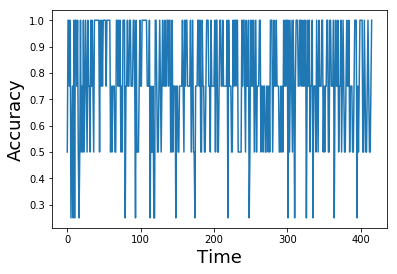

[38.8655153 27.6017182 60.6395993 86.6087568]
Last predicted actions:  [0, 0, 0, 1]
Last expected actions:  [0, -1, 0, 1]
Last accuracy (%):  75.0
[27.6649022 33.8991663 41.2079724 75.1743391]
Last predicted actions:  [0, 0, 0, 1]
Last expected actions:  [-1, 0, 0, 1]
Last accuracy (%):  75.0
[37.4923291 33.1221184 55.2629872 89.3885988]
Last predicted actions:  [0, 0, 0, 1]
Last expected actions:  [0, 0, 0, 1]
Last accuracy (%):  100.0
[35.3328784 32.0044407 49.7285685 94.2142032]
Last predicted actions:  [0, 0, 0, 1]
Last expected actions:  [0, 0, 0, 1]
Last accuracy (%):  100.0
[31.065084  31.1951572 52.7379113 83.5315548]
Last predicted actions:  [0, 0, 0, 1]
Last expected actions:  [0, 0, 0, 1]
Last accuracy (%):  100.0
[ 41.2446506  32.2005643  57.4949308 111.8669358]
Last predicted actions:  [0, 0, 0, 1]
Last expected actions:  [0, 0, 0, 1]
Last accuracy (%):  100.0
[ 36.274242   34.7281967  55.623514  105.1339515]
Last predicted actions:  [0, 0, 0, 1]
Last expected actions:  [0

In [50]:
plot_line_graph(test.accuracy_list)

In [52]:
sched.shutdown() # shutdown the scheduler

In [54]:
print(sum(test.accuracy_list) / len(test.accuracy_list))

0.7661662817551963
